In [72]:
import numpy as np

def raw2array(file_name):
    """
    conveft interfile to numpy array
    :param param: dict contens interfile poarametrs
    :return:
    """

    f = open(file_name, 'r')
    v_list = np.fromfile(f, dtype=np.float32)
    f.close()
    resh_arr = np.asarray(v_list).reshape((850, 250,250))
    return resh_arr
             
def mm2pixel(x, size, mm_px = 2.0):
    return int(x/mm_px+size/2)

READ input file 
-----------------

In [61]:
def get_activity_source(file_name):
    activity={}
    true ={}
    with open(file_name, 'r') as f:
        for line in f.readlines():
            con = line.split('\t')
            point_source_pos = (con[13], con[14], con[15])
            activity[point_source_pos] = activity.get(point_source_pos, 0) + 1
            if con[12] == '1':
                true[point_source_pos] = true.get(point_source_pos, 0) + 1
        _max = max(activity.values())
        print('source position      \t    norm.act.\t trues fraction')
        for source in activity:
            true[source] = np.round(true[source]/activity[source],2)
            activity[source] = np.round(activity[source]/_max,2)
            print('%s\t%s\t%s' % (source, activity[source], true[source]))

            
        
            
get_activity_source('output_coincidences')

source position      	    norm.act.	 trues fraction
('10.00', '0.00', '0.00')	0.92	0.57
('20.00', '0.00', '75.00')	0.64	0.49
('1.00', '0.00', '0.00')	0.9	0.57
('10.00', '0.00', '75.00')	0.53	0.47
('20.00', '0.00', '0.00')	1.0	0.56
('1.00', '0.00', '75.00')	0.51	0.45


6 point sources reconstruction
=========
* name - `output_coincidences`
* format -  `GOJA`
* Number of coicdences - 199227
* 2 layer Modular Geometry



* different activities ??? (20,0,75) twice as much as (1,0,75)
* Only half the coincidence is true ???


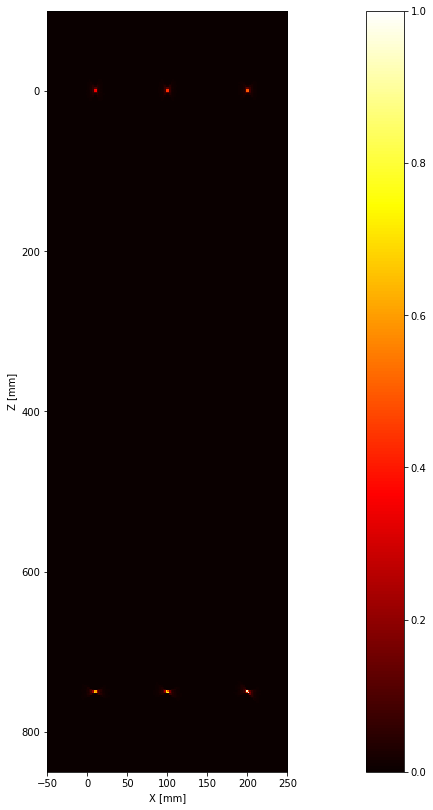

In [58]:
from matplotlib import pyplot as plt
image = raw2array("m_qetir.raw")

def show_zx_map(image):
    z_limit = 850
    x_limit =250
    y_0 = mm2pixel(0,250)
    x_0 = mm2pixel(-50,250)
    z_0 = mm2pixel(-100,850) 

    _array = image[z_0:,y_0,x_0:]
    plt.figure(figsize=(28, 14))
    phantom_maximum = max(_array.flatten())
    _array=(_array-min(_array.flatten()))
    _array = (_array/phantom_maximum)
    plt.xlabel('X [mm]')
    plt.ylabel('Z [mm]')
    plt.xlim([-50, x_limit])
    plt.imshow(_array, cmap="hot", origin='upper', extent=[-50, x_limit, z_limit, -100])
    plt.colorbar()

show_zx_map(image)


QETIR MLEM-TOF reconstruction 1st iteration
---------------------------

In [14]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def fit_gauss(x,y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
    popt,pcov = curve_fit(Gauss, x, y, p0=[max(y), mean, sigma])
    print("pos_mean :%s, FWHM = %s [mm], max value : %s" % (np.round(mean,1) , np.round(2.35*popt[2]*2,2), np.round(max(y),2)))
    return x, Gauss(x, *popt)

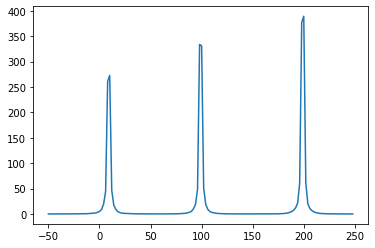

pos_mean :9.0, FWHM = 7.12 [mm], max value : 272.76
pos_mean :99.0, FWHM = 6.88 [mm], max value : 333.81
pos_mean :199.0, FWHM = 6.97 [mm], max value : 389.33


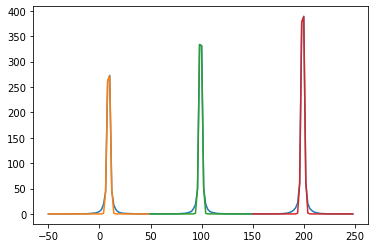

In [73]:

# profile z=0 mm, y=0mm
def show_x_profile(image):
    z_0 = mm2pixel(0,850)
    y_0 = mm2pixel(0,250)
    x_args = np.arange(-250,250,2)
    plt.plot(x_args[100:], image[z_0,y_0,:][100:])
    plt.show()

    plt.plot(x_args[100:], image[z_0,y_0,:][100:])
    plt.plot(*fit_gauss(x_args[100:150],image[z_0,y_0,:][100:150] ))
    plt.plot(*fit_gauss(x_args[150:200],image[z_0,y_0,:][150:200] ))
    plt.plot(*fit_gauss(x_args[200:250],image[z_0,y_0,:][200:250] ))
show_x_profile(image)
# print(fit_gauss(x_args[100:150],image[z_0,y_0,:][100:150] ))


X axis (Z=0), X profile with fit  Gauss functions
-------------------

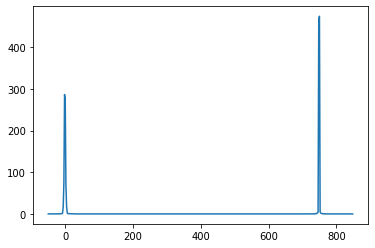

pos_mean :-1.0, FWHM = 8.21 [mm], max value : 286.59
pos_mean :749.0, FWHM = 4.36 [mm], max value : 474.48


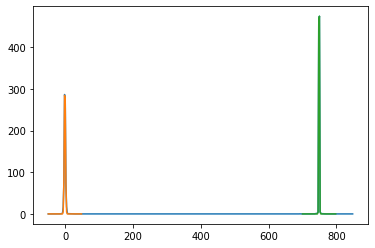

In [77]:
def show_z_profile(image):
    x_0 = mm2pixel(10,250)
    y_0 = mm2pixel(0,250)
    z_args = np.arange(-850,850,2)
    plt.plot(z_args[400:], image[:,y_0,x_0][400:])
    plt.show()
    plt.plot(z_args[400:], image[:,y_0,x_0][400:])
    plt.plot(*fit_gauss(z_args[400:450],image[:,y_0,x_0][400:450] ))
    plt.plot(*fit_gauss(z_args[775:825],image[:,y_0,x_0][775:825] ))
show_z_profile(image)

Z profile , X=10 mm 
-----------

In [78]:
#integrate
def sum_activity(image):
    d = 25
    source_points = []
    source_xz_pos = [(10,0),(100,0),(200,0),(10,750),(100,750),(200,750)]
    for ps in source_xz_pos:
        ps = (mm2pixel(ps[0],250), mm2pixel(ps[1], 850), mm2pixel(0,250))
        source_points.append(sum(image[ps[1]-d:ps[1]+d,ps[2]-d:ps[2]+d, ps[0]-d:ps[0]+d].flatten()))

    for point in zip(source_xz_pos, np.round(source_points/max(source_points),2)):
        print("Source pos(x,z) : %s area %.2f"  % point )
sum_activity(image)

Source pos(x,z) : (10, 0) area 0.57
Source pos(x,z) : (100, 0) area 0.65
Source pos(x,z) : (200, 0) area 0.75
Source pos(x,z) : (10, 750) area 0.94
Source pos(x,z) : (100, 750) area 0.97
Source pos(x,z) : (200, 750) area 1.00


Area means normed activity
==============

QETIR with sens map generate in CASTOR
===========

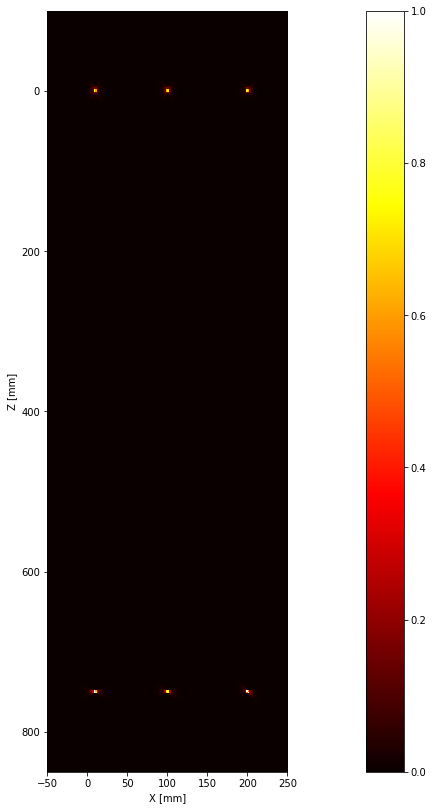

In [64]:
image_castor_sens_map = raw2array("m_castor.raw")
show_zx_map(image_castor_sens_map)

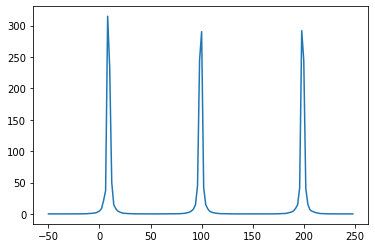

pos_mean :8.9, FWHM = 6.57 [mm], max value : 314.87
pos_mean :99.0, FWHM = 6.91 [mm], max value : 290.3
pos_mean :198.9, FWHM = 6.79 [mm], max value : 291.84


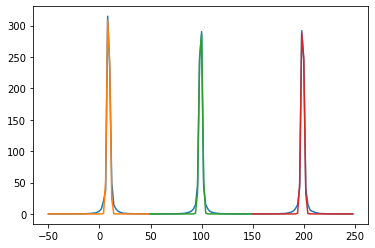

In [18]:
show_x_profile(image_castor_sens_map)

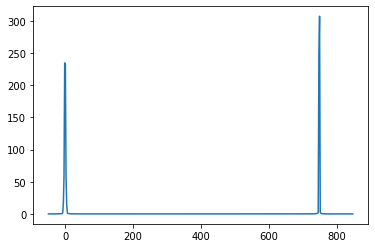

pos_mean :-1.0, FWHM = 8.08 [mm], max value : 234.69
pos_mean :749.1, FWHM = 4.31 [mm], max value : 307.24


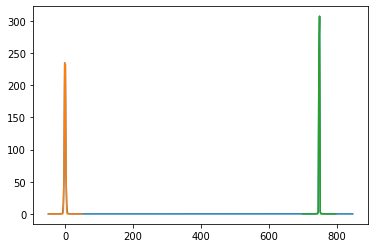

In [65]:
show_z_profile(image_castor_sens_map)

In [79]:
sum_activity(image_castor_sens_map)

Source pos(x,z) : (10, 0) area 0.88
Source pos(x,z) : (100, 0) area 0.89
Source pos(x,z) : (200, 0) area 0.89
Source pos(x,z) : (10, 750) area 1.00
Source pos(x,z) : (100, 750) area 0.98
Source pos(x,z) : (200, 750) area 0.95
